# Topic Modeling with Earnings Call Transcripts

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import seaborn as sns
from ipywidgets import interact, FloatRangeSlider

# spacy for language processing
import spacy

# sklearn for feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words

# gensim for topic models
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

# topic model viz
import pyLDAvis
from pyLDAvis.gensim import prepare

# evaluate parameter settings
import statsmodels.api as sm

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [3]:
sns.set_style('white')

In [4]:
pyLDAvis.enable_notebook()

In [6]:
stop_words = set(pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words', 
                         header=None, 
                         squeeze=True))

## Load Earnings Call Transcripts

In [5]:
PROJECT_DIR = Path().cwd().parent
data_path = PROJECT_DIR / 'data' / 'earnings_calls'

The document are the result of scraping the [SeekingAlpha Earnings Transcripts](https://seekingalpha.com/earnings/earnings-call-transcripts) as described in n Chapter 3 on [Alternative Data](../../03_alternative_data/02_earnings_calls).

The transcripts consist of individual statements by company representative, an operator and usually a Q&A session with analysts. We will treat each of these statements as separate documents, ignoring operator statements, to obtain 22,766 items with mean and median word counts of 144 and 64, respectively (or as many as you were able to scrape):

In [7]:
documents = []
for i, transcript in enumerate(data_path.iterdir()):
    content = pd.read_csv(transcript / 'content.csv')
    documents.extend(content.loc[(content.speaker!='Operator') & (content.content.str.len() > 5), 'content'].tolist())

In [8]:
len(documents)

32047

## Explore Data

### Tokens per document

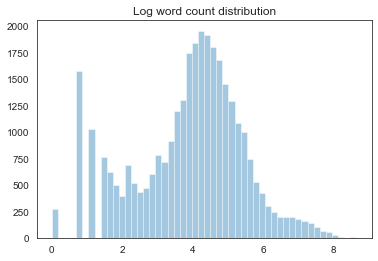

In [9]:
word_count = pd.Series(documents).str.split().str.len()
ax = sns.distplot(np.log(word_count), kde=False)
ax.set_title('Log word count distribution')
sns.despine();

In [10]:
word_count.describe(percentiles=np.arange(.1, 1.0, .1))

count   32,047.00
mean       137.33
std        283.60
min          1.00
10%          4.00
20%         12.00
30%         28.00
40%         45.00
50%         62.00
60%         82.00
70%        111.00
80%        161.00
90%        273.00
max      5,718.00
dtype: float64

In [11]:
token_count = Counter()
for i, doc in enumerate(documents, 1):
    if i % 5000 == 0:
        print(i, end=' ', flush=True)
    token_count.update(doc.split())

5000 10000 15000 20000 25000 30000 

### Most frequent tokens

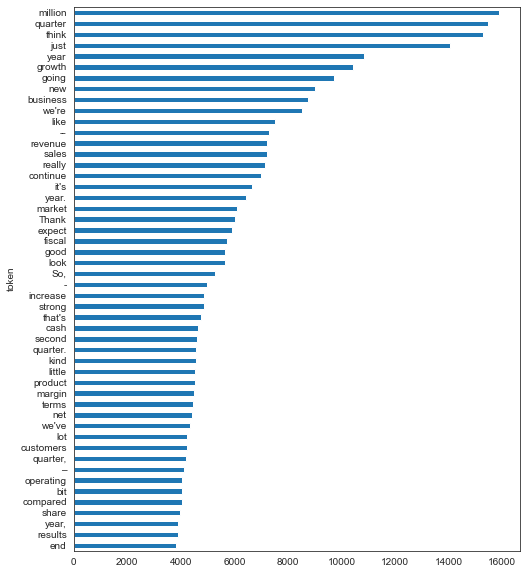

In [12]:
(pd.DataFrame(token_count.most_common(), columns=['token', 'count'])
 .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)])
 .set_index('token')
 .squeeze()
 .iloc[:50]
 .sort_values()
 .plot
 .barh(figsize=(8, 10)))
sns.despine()
plt.tight_layout();

## Preprocess Transcripts

We use spaCy to preprocess these documents as illustrated in [Chapter 13 - Working with Text Data](../../13_working%20with_text_data) and store the cleaned and lemmatized text as a new text file. 

Data exploration reveals domain-specific stopwords like ’year’ and ‘quarter’ that we remove in a second step, where we also filter out statements with fewer than 10 words so that some 16,150 remain.

In [13]:
def clean_doc(d):
    doc = []
    for t in d:
        if not any([t.is_stop, t.is_digit, not t.is_alpha, t.is_punct, t.is_space, t.lemma_ == '-PRON-']):        
            doc.append(t.lemma_)
    return ' '.join(doc)    

In [14]:
nlp = spacy.load('en')
iter_docs = (doc for doc in documents)
clean_docs = []
for i, document in enumerate(nlp.pipe(iter_docs, batch_size=100, n_process=8), 1):  
    if i % 1000 == 0: 
        print(f'{i/len(documents):.2%}', end=' ', flush=True)
    clean_docs.append(clean_doc(document))

3.12% 6.24% 9.36% 12.48% 15.60% 18.72% 21.84% 24.96% 28.08% 31.20% 34.32% 37.45% 40.57% 43.69% 46.81% 49.93% 53.05% 56.17% 59.29% 62.41% 65.53% 68.65% 71.77% 74.89% 78.01% 81.13% 84.25% 87.37% 90.49% 93.61% 96.73% 99.85% 

In [16]:
results_path = Path('results', 'earnings_calls')
if not results_path.exists():
    results_path.mkdir()

In [17]:
clean_text = results_path / 'clean_text.txt'

In [18]:
clean_text.write_text('\n'.join(clean_docs))

14079406

## Vectorize data

In [19]:
docs = []
for line in clean_text.read_text().split('\n'):
    line = [t for t in line.split() if t not in stop_words]
    if len(line) > 10:
        docs.append(' '.join(line))

len(docs)

22571

In [20]:
token_count = Counter()
for i, doc in enumerate(docs, 1):
    if i % 5000 == 0:
        print(i, end=' ', flush=True)
    token_count.update(doc.split())
token_count = pd.DataFrame(token_count.most_common(), columns=['token', 'count'])    

5000 10000 15000 20000 

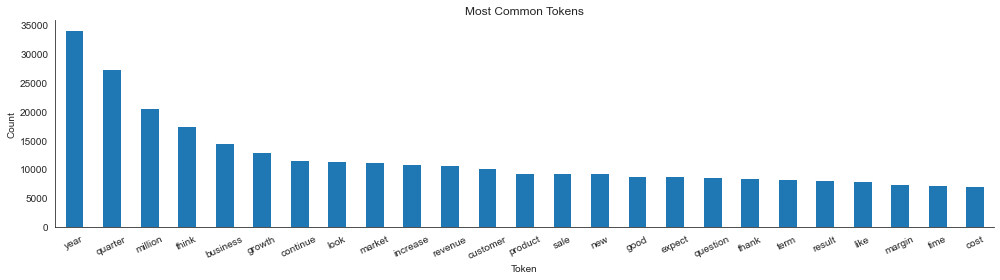

In [21]:
ax = (token_count.set_index('token').squeeze().iloc[:25].sort_values(
    ascending=False).plot.bar(figsize=(14, 4), rot=25, title='Most Common Tokens'))
ax.set_ylabel('Count')
ax.set_xlabel('Token')
sns.despine()
plt.gcf().tight_layout()

In [22]:
frequent_words = token_count.head(50).token.tolist()
binary_vectorizer = CountVectorizer(max_df=1.0,
                             min_df=1,
                             stop_words=frequent_words,
                             max_features=None,
                             binary=True)

binary_dtm = binary_vectorizer.fit_transform(docs)

n_docs, n_tokens = binary_dtm.shape
doc_freq = pd.Series(np.array(binary_dtm.sum(axis=0)).squeeze()).div(binary_dtm.shape[0])
max_unique_tokens = np.array(binary_dtm.sum(axis=1)).squeeze().max()

In [23]:
df_range = FloatRangeSlider(value=[0.0, 1.0],
                            min=0,
                            max=1,
                            step=0.0001,
                            description='Doc. Freq.',
                            disabled=False,
                            continuous_update=True,
                            orientation='horizontal',
                            readout=True,
                            readout_format='.1%',
                            layout={'width': '800px'})

@interact(df_range=df_range)
def document_frequency_simulator(df_range):
    min_df, max_df = df_range
    keep = doc_freq.between(left=min_df, right=max_df)
    left = keep.sum()

    fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
    updated_dtm = binary_dtm.tocsc()[:, np.flatnonzero(keep)]
    unique_tokens_per_doc = np.array(updated_dtm.sum(axis=1)).squeeze()
    sns.distplot(unique_tokens_per_doc, ax=axes[0], kde=False, norm_hist=False)
    axes[0].set_title('Unique Tokens per Doc')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('# Unique Tokens')
    axes[0].set_ylabel('# Documents (log scale)')
    axes[0].set_xlim(0, max_unique_tokens)    
    axes[0].yaxis.set_major_formatter(ScalarFormatter())

    term_freq = pd.Series(np.array(updated_dtm.sum(axis=0)).squeeze())
    sns.distplot(term_freq, ax=axes[1], kde=False, norm_hist=False)
    axes[1].set_title('Document Frequency')
    axes[1].set_ylabel('# Tokens')
    axes[1].set_xlabel('# Documents')
    axes[1].set_yscale('log')
    axes[1].set_xlim(0, n_docs)

    title = f'Document/Term Frequency Distribution | # Tokens: {left:,d} ({left/n_tokens:.2%})'
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='Doc. Freq.', layout=Layout(width='800px'…

## Train & Evaluate LDA Model

In [25]:
def show_word_list(model, corpus, top=10, save=False):
    top_topics = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    words, probs = [], []
    for top_topic, _ in top_topics:
        words.append([t[1] for t in top_topic[:top]])
        probs.append([t[0] for t in top_topic[:top]])

    fig, ax = plt.subplots(figsize=(model.num_topics*1.2, 5))
    sns.heatmap(pd.DataFrame(probs).T,
                annot=pd.DataFrame(words).T,
                fmt='',
                ax=ax,
                cmap='Blues',
                cbar=False)
    sns.despine()
    fig.tight_layout()
    if save:
        fig.savefig(results_path / 'earnings_call_wordlist', dpi=300)

In [26]:
def show_coherence(model, corpus, tokens, top=10, cutoff=0.01):
    top_topics = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    word_lists = pd.DataFrame(model.get_topics().T, index=tokens)
    order = []
    for w, word_list in word_lists.items():
        target = set(word_list.nlargest(top).index)
        for t, (top_topic, _) in enumerate(top_topics):
            if target == set([t[1] for t in top_topic[:top]]):
                order.append(t)

    fig, axes = plt.subplots(ncols=2, figsize=(15,5))
    title = f'# Words with Probability > {cutoff:.2%}'
    (word_lists.loc[:, order]>cutoff).sum().reset_index(drop=True).plot.bar(title=title, ax=axes[1]);

    umass = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    pd.Series([c[1] for c in umass]).plot.bar(title='Topic Coherence', ax=axes[0])
    sns.despine()
    fig.tight_layout();

In [27]:
def show_top_docs(model, corpus, docs):
    doc_topics = model.get_document_topics(corpus)
    df = pd.concat([pd.DataFrame(doc_topic, 
                                 columns=['topicid', 'weight']).assign(doc=i) 
                    for i, doc_topic in enumerate(doc_topics)])

    for topicid, data in df.groupby('topicid'):
        print(topicid, docs[int(data.sort_values('weight', ascending=False).iloc[0].doc)])
        print(pd.DataFrame(lda.show_topic(topicid=topicid)))

### Vocab Settings

For illustration, we create a document-term matrix containing terms appearing in between 0.5% and 50% of documents for around 1,560 features. 

In [28]:
min_df = .005
max_df=.25
ngram_range=(1, 1)
binary = False

In [29]:
vectorizer = CountVectorizer(stop_words=frequent_words,
                             min_df=min_df,
                             max_df=max_df,
                             ngram_range=ngram_range,
                             binary=binary)

In [30]:
dtm = vectorizer.fit_transform(docs)
tokens = vectorizer.get_feature_names()
dtm.shape

(22571, 1526)

In [31]:
corpus = Sparse2Corpus(dtm, documents_columns=False)
id2word = pd.Series(tokens).to_dict()
dictionary = Dictionary.from_corpus(corpus, id2word)

### Model Settings

In [32]:
num_topics=15
chunksize=50000
passes=25
update_every=None
alpha='auto'
eta='auto'
decay=0.5
offset=1.0
eval_every=None
iterations=50
gamma_threshold=0.001
minimum_probability=0.01
minimum_phi_value=0.01
per_word_topics=False

Training a 15 topic model using 25 passes over the corpus takes a bit over two minutes on a 4-core i7.
The top 10 words per topic identify several distinct themes that range from obvious financial information to clinical trials (topic 4) and supply chain issues (12).

In [33]:
lda = LdaModel(corpus=corpus,
               id2word=id2word,
               num_topics=num_topics,
               chunksize=chunksize,
               update_every=update_every,
               alpha=alpha,
               eta=eta,
               decay=decay,
               offset=offset,
               eval_every=eval_every,
               passes=passes,
               iterations=iterations,
               gamma_threshold=gamma_threshold,
               minimum_probability=minimum_probability,
               minimum_phi_value=minimum_phi_value,
               random_state=42)

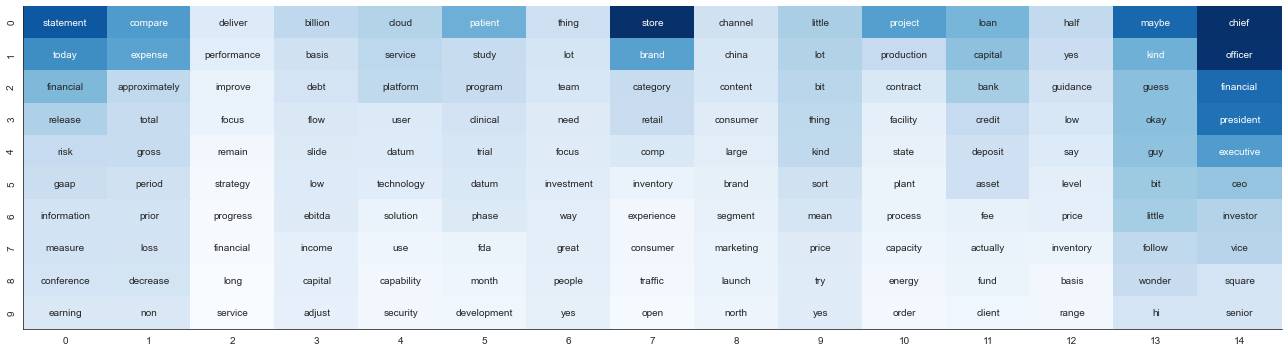

In [34]:
show_word_list(model=lda, corpus=corpus, save=True)

### Topic Coherence

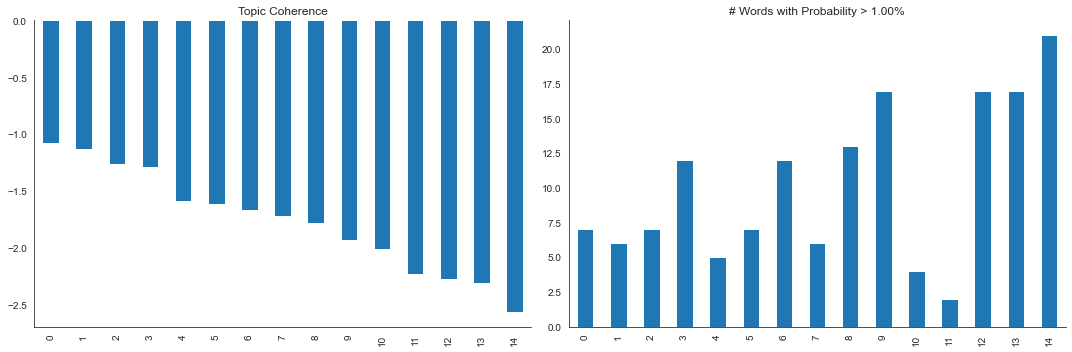

In [35]:
show_coherence(model=lda, corpus=corpus, tokens=tokens)

### pyLDAVis

In [36]:
vis = prepare(lda, corpus, dictionary, mds='tsne')
pyLDAvis.display(vis)

In [40]:
pyLDAvis.save_html(vis, (results_path / f'lda_15.html').as_posix())

### Show documents most represenative of each topic

In [41]:
show_top_docs(model=lda, corpus=corpus, docs=docs)

0 sure happy talk strategy Steve look big series announcement Dell Technologies World handful week ago talk Dell Technologies Cloud specifically talk build cloud platform base HCI CI stack VMware Cloud Foundation organization want deploy prem cloud hybrid cloud consistency management automation provide tool high level integration VxRail VCF product VMware VCF product think differentiated offer continue build add capability talk extension platform primary storage array continue able enable customer build edge deployment core datum center deployment offer announce data center service basically ability public cloud experience prem private cloud deliver service private datum center edge network fully manage offer subscription build VxRail VMware Cloud Foundation install manage cut like cloud service customer consume today extend cloud strategy announcement Microsoft essentially allow customer want use public cloud public cloud service VMware software define datum center run cloud include A

## Review Experiment Results

To illustrate the impact of different parameter settings, we run a few hundred experiments for different DTM constraints and model parameters. More specifically, we let the min_df and max_df parameters range from 50-500 words and 10% to 100% of documents, respectively using alternatively binary and absolute counts. We then train LDA models with 3 to 50 topics, using 1 and 25 passes over the corpus.

The script [run_experiments.py](run_experiments.py) lets you train many topic models with different hyperparameters to explore how they impact the results. The script [collect_experiments.py](collect_experiments.py) combines the results into a `results.h5` HDF store.

These results are not included in the repository due to their size, but the results are displayed and you can rerun these experiments with earnings call transcripts or other text documents of your choice.

In [43]:
with pd.HDFStore(results_path / 'results.h5') as store:
    perplexity = store.get('perplexity')
    coherence = store.get('coherence')

In [44]:
perplexity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496 entries, 0 to 15
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   vocab_size  496 non-null    int64  
 1   test_vocab  496 non-null    int64  
 2   min_df      496 non-null    int64  
 3   max_df      496 non-null    float64
 4   binary      496 non-null    bool   
 5   num_topics  496 non-null    int64  
 6   passes      496 non-null    int64  
 7   perplexity  496 non-null    float64
dtypes: bool(1), float64(2), int64(5)
memory usage: 31.5 KB


In [45]:
coherence.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8370 entries, 0 to 713
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   topic       8370 non-null   int64  
 1   passes      8370 non-null   object 
 2   num_topics  8370 non-null   object 
 3   coherence   8370 non-null   float64
 4   min_df      8370 non-null   int64  
 5   max_df      8370 non-null   float64
 6   binary      8370 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 465.9+ KB


### Parameter Settings: Impact on Perplexity

In [46]:
X = perplexity[['min_df', 'max_df', 'binary', 'num_topics','passes']]
X = pd.get_dummies(X, columns=X.columns, drop_first=True)
ols = sm.OLS(endog=perplexity.perplexity, exog=sm.add_constant(X))
model = ols.fit(cov_type='HC0')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             perplexity   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     75.71
Date:                Sat, 20 Jun 2020   Prob (F-statistic):          5.53e-116
Time:                        16:35:51   Log-Likelihood:                -2407.9
No. Observations:                 496   AIC:                             4848.
Df Residuals:                     480   BIC:                             4915.
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           158.0331      5.804     27.227

### Parameter Settings: Impact on Coherence

In [47]:
X = coherence.drop('coherence', axis=1)
X = pd.get_dummies(X, columns=X.columns, drop_first=True)
ols = sm.OLS(endog=coherence.coherence, exog=sm.add_constant(X))
model = ols.fit(cov_type='HC0')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              coherence   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     237.0
Date:                Sat, 20 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:35:55   Log-Likelihood:                -4925.0
No. Observations:                8370   AIC:                             9980.
Df Residuals:                    8305   BIC:                         1.044e+04
Df Model:                          64                                         
Covariance Type:                  HC0                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.5492      0.023    -66.490

### Hyperparameter Impact on Perplexity

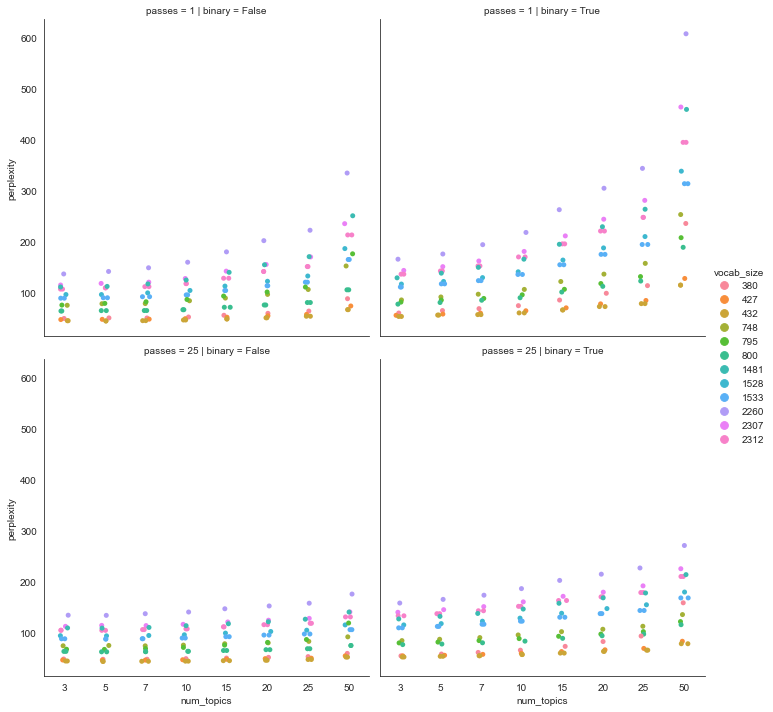

In [48]:
sns.catplot(x='num_topics',
            y='perplexity',
            data=perplexity,
            hue='vocab_size',
            col='binary',
            row='passes',
            kind='strip');

In [49]:
coherence.num_topics = coherence.num_topics.apply(lambda x: f'model_{int(x):0>2}')
perplexity.min_df = perplexity.min_df.apply(lambda x: f'min_df_{int(x):0>3}')

### Hyperparameter Impact on Topic Coherence

The following chart illustrate the results in terms of topic coherence (higher is better) ,and perplexity (lower is better). Coherence drops after 25-30 topics, and perplexity similarly increases. 

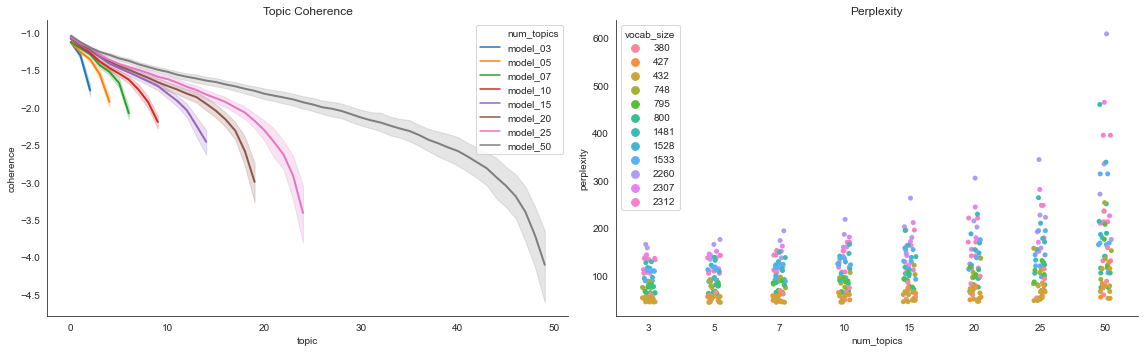

In [50]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))
data = coherence.sort_values('num_topics')
sns.lineplot(x='topic', y='coherence', hue='num_topics', data=data, lw=2, ax=axes[0])
axes[0].set_title('Topic Coherence')
sns.stripplot(x='num_topics', y='perplexity', hue='vocab_size', data=perplexity, lw=2, ax=axes[1])
axes[1].set_title('Perplexity')
sns.despine()
fig.tight_layout();